# My Own Code for Scraping/Cleaning Netflix Data

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time


In [ ]:
# login creds
mail = "x"
pw = "x" # 

driver = webdriver.Chrome()

driver.get("https://www.netflix.com/tr-en/login")

In [ ]:
# wait for xpath to load
wait = WebDriverWait(driver, 10) 

email_input = wait.until(EC.element_to_be_clickable((By.XPATH, '//input[@name="userLoginId"]'))) 
password_input = wait.until(EC.element_to_be_clickable((By.XPATH, '//input[@name="password"]')))  

# login
email_input.send_keys(mail)
password_input.send_keys(pw)
password_input.submit()

In [ ]:

def select_profile(driver, profile_name):
    try:
        profile_selector = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//*[@id="appMountPoint"]/div/div/div/div[1]/div[1]/div[2]/div/div/ul'))
        )
        
        profile_elements = profile_selector.find_elements(By.XPATH, './/li//a//span')
        
        # this was just for scraping and debugging and finding the proper part for profiles, not necessary
        print("Available profiles:")
        for profile in profile_elements:
            print(profile.text)
        
        for profile in profile_elements:
            if profile.text.strip() == profile_name: 
                profile.click()
                print(f"Selected profile: {profile_name}")
                return
        print(f"Profile '{profile_name}' not found.")
        
    except TimeoutException:
        print("Failed to find the profile list or the profile selector.")

In [ ]:
# select profile and go to history page
profilename = "x"
select_profile(driver, profilename)

time.sleep(7) # 7 sec sleep to login, connection may be slow
viewActivityPage = "https://www.netflix.com/viewingactivity?u=0&p="

# activity page for a specific profile of mine
driver.get(viewActivityPage + profilename)

# wait for loading
history_list = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[1]/div/div/div/div[2]/div/div/ul')))


In [ ]:
def download_file(driver):
    try:
        download_button_xpath = "/html/body/div[1]/div/div/div/div[2]/div/div/div[2]/div[2]/a[2]"
        
        download_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, download_button_xpath))
        )
        
        download_button.click()
        print("Download started.")
        
        WebDriverWait(driver, 5).until(EC.staleness_of(download_button))
        
        driver.quit()

    except TimeoutException:
        print("Download button not found or clickable.")
        driver.quit()

download_file(driver)


----
Second Phase - Cleaning the data

In [15]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # Add this import
from collections import defaultdict

In [ ]:

# read csv
netflix_data = pd.read_csv('../data/NetflixViewingHistory.csv')

# Import local module
import sys
sys.path.append('../src')
from data_visualization import *

# df
split_columns = pd.DataFrame()

# split seasons
split_columns = netflix_data['Title'].str.extract(r'^(.*?)(?:: Season (\d+))?: (.*)$')
split_columns.columns = ['Series', 'Season', 'Episode']

# movies and shows maybe
split_columns['Series'].fillna(netflix_data['Title'], inplace=True)

# missing vals
split_columns['Season'].fillna('Movie', inplace=True)  
split_columns['Episode'].fillna('Movie', inplace=True)  

# Data Type Conversion 'Season'
split_columns['Season'] = split_columns['Season'].astype('category')

netflix_data_cleaned = pd.concat([netflix_data.drop(columns=['Title']), split_columns], axis=1)

# cleaned dataframe
netflix_data_cleaned


In [5]:
netflix_data_cleaned

,Date,Series,Season,Episode
0,11/29/24,G.O.R.A,Movie,Movie
1,11/28/24,Our Father,Movie,Movie
2,11/9/24,Better Call Saul,6,Plan and Execution
3,11/9/24,Better Call Saul,5,Something Unforgivable
4,11/6/24,The Interview,Movie,Movie
...,...,...,...,...
2196,1/19/16,Journey 2,Movie,The Mysterious Island
2197,1/19/16,,Movie,Movie
2198,1/10/16,The Royals,Movie,Royal Weddings
2199,1/9/16,The Conjuring,Movie,Movie


In [ ]:
# Add after your existing cleaning code
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

# Convert date to datetime
netflix_data_cleaned['Date'] = pd.to_datetime(netflix_data_cleaned['Date'])

# Add temporal features
netflix_data_cleaned['Year'] = netflix_data_cleaned['Date'].dt.year
netflix_data_cleaned['Month'] = netflix_data_cleaned['Date'].dt.month
netflix_data_cleaned['Day'] = netflix_data_cleaned['Date'].dt.day
netflix_data_cleaned['Weekday'] = netflix_data_cleaned['Date'].dt.day_name()
netflix_data_cleaned['Season'] = pd.cut(netflix_data_cleaned['Date'].dt.month, 
                                      bins=[0,3,6,9,12], 
                                      labels=['Winter', 'Spring', 'Summer', 'Fall'])


In [7]:
def analyze_viewing_trends(df):
    """Analyze viewing patterns over time"""
    
    # Monthly viewing counts
    df['YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
    monthly_views = df.groupby('YearMonth').size()
    
    # Year-over-year comparison
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    yearly_views = df.groupby('Year').size()
    
    # Weekday patterns
    df['Weekday'] = pd.to_datetime(df['Date']).dt.day_name()
    weekday_views = df.groupby('Weekday').size()
    
    # Visualize
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    monthly_views.plot(kind='line', ax=ax1)
    ax1.set_title('Monthly Viewing Trends')
    ax1.set_ylabel('Number of Views')
    
    yearly_views.plot(kind='bar', ax=ax2)
    ax2.set_title('Yearly Viewing Distribution')
    ax2.set_ylabel('Number of Views')
    
    weekday_views.plot(kind='bar', ax=ax3)
    ax3.set_title('Weekday Viewing Patterns')
    ax3.set_ylabel('Number of Views')
    
    plt.tight_layout()
    return monthly_views, yearly_views, weekday_views

In [ ]:
def analyze_series_patterns(df):
    """Detailed analysis of series watching behavior"""
    
    # Most watched series
    series_counts = df[df['Episode'] != 'Movie'].groupby('Series').size().sort_values(ascending=False)
    
    # Average time between episodes for each series - FIXED
    df_series = df[df['Episode'] != 'Movie'].copy()
    df_series['Date'] = pd.to_datetime(df_series['Date'])
    df_series = df_series.sort_values('Date')
    
    series_gaps = {}
    for series in df_series['Series'].unique():
        series_data = df_series[df_series['Series'] == series]
        if len(series_data) > 1:  # Only calculate for series with multiple episodes
            # Calculate gaps for each season separately
            series_data = series_data.sort_values('Date')
            gaps = series_data.groupby('Season')['Date'].diff().dropna()
            if not gaps.empty:
                avg_gap = gaps.mean().days if hasattr(gaps.mean(), 'days') else gaps.mean() / pd.Timedelta(days=1)
                if avg_gap > 0:  # Only include positive gaps
                    series_gaps[series] = avg_gap
    
    series_gaps = pd.Series(series_gaps)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    series_counts.head(10).plot(kind='barh', ax=ax1)
    ax1.set_title('Top 10 Most Watched Series')
    
    if not series_gaps.empty:
        series_gaps.sort_values().head(10).plot(kind='barh', ax=ax2)
        ax2.set_title('Average Days Between Episodes (Top 10 Most Frequently Watched)')
    else:
        ax2.text(0.5, 0.5, 'No valid gap data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    
    # Print detailed statistics
    print("\nDetailed Series Statistics:")
    print(f"Total unique series: {len(series_counts)}")
    if not series_gaps.empty:
        print(f"Average gap between episodes (overall): {series_gaps.mean():.1f} days")
        print("\nTop 5 Series with Shortest Viewing Gaps:")
        print(series_gaps.sort_values().head())
    
    return series_counts, series_gaps

# Execute the analysis
series_counts, series_gaps = analyze_series_patterns(netflix_data_cleaned)

In [9]:
def analyze_content_distribution(df):
    """Analyze movie vs series viewing patterns"""
    
    # Basic counts
    content_type = df['Episode'].apply(lambda x: 'Movie' if x == 'Movie' else 'Series').value_counts()
    
    # Monthly distribution of movies vs series
    df['YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
    df['ContentType'] = df['Episode'].apply(lambda x: 'Movie' if x == 'Movie' else 'Series')
    monthly_type_dist = df.pivot_table(
        index='YearMonth', 
        columns='ContentType', 
        aggfunc='size',
        fill_value=0
    )
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    content_type.plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    ax1.set_title('Movie vs Series Distribution')
    
    monthly_type_dist.plot(kind='line', ax=ax2)
    ax2.set_title('Monthly Movie vs Series Viewing')
    ax2.set_ylabel('Number of Views')
    
    plt.tight_layout()
    return content_type, monthly_type_dist

In [10]:
def analyze_binge_patterns(df):
    """Detailed binge watching analysis"""
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['DateOnly'] = df['Date'].dt.date
    
    # Define binge sessions (3+ views per day)
    binge_data = []
    for date, group in df.groupby('DateOnly'):
        if len(group) >= 3:
            binge_data.append({
                'date': date,
                'count': len(group),
                'content': group['Series'].tolist(),
                'type': 'Mixed' if (group['Episode'] == 'Movie').any() else 'Series'
            })
    
    binge_df = pd.DataFrame(binge_data)
    
    # Analyze patterns
    if not binge_df.empty:
        binge_df['month'] = pd.to_datetime(binge_df['date']).dt.month
        monthly_binges = binge_df.groupby('month')['count'].agg(['mean', 'max', 'count'])
        
        # Most common binge series
        all_binge_content = [item for sublist in binge_df['content'] for item in sublist]
        binge_series = pd.Series(all_binge_content).value_counts()
        
        # Visualize
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        monthly_binges['mean'].plot(kind='bar', ax=ax1)
        ax1.set_title('Average Binge Size by Month')
        
        monthly_binges['count'].plot(kind='bar', ax=ax2)
        ax2.set_title('Number of Binge Days by Month')
        
        binge_series.head(10).plot(kind='barh', ax=ax3)
        ax3.set_title('Most Common Series in Binge Sessions')
        
        binge_df['count'].hist(ax=ax4, bins=20)
        ax4.set_title('Distribution of Binge Session Sizes')
        
        plt.tight_layout()
        return monthly_binges, binge_series
    
    return None, None

In [11]:
def analyze_seasonal_patterns(df):
    """Analyze viewing patterns across seasons and holidays"""
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Season'] = pd.cut(df['Date'].dt.month, 
                         bins=[0,3,6,9,12], 
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    # Seasonal viewing patterns
    seasonal_views = df.groupby('Season').size()
    
    # Content type by season
    seasonal_content = df.pivot_table(
        index='Season',
        columns=df['Episode'].apply(lambda x: 'Movie' if x == 'Movie' else 'Series'),
        aggfunc='size',
        fill_value=0
    )
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    seasonal_views.plot(kind='bar', ax=ax1)
    ax1.set_title('Viewing Distribution by Season')
    
    seasonal_content.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Content Type Distribution by Season')
    
    plt.tight_layout()
    return seasonal_views, seasonal_content

In [12]:
def analyze_seasonal_patterns(df):
    """Analyze viewing patterns across seasons and holidays"""
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Season'] = pd.cut(df['Date'].dt.month, 
                         bins=[0,3,6,9,12], 
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    # Seasonal viewing patterns
    seasonal_views = df.groupby('Season').size()
    
    # Content type by season
    seasonal_content = df.pivot_table(
        index='Season',
        columns=df['Episode'].apply(lambda x: 'Movie' if x == 'Movie' else 'Series'),
        aggfunc='size',
        fill_value=0
    )
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    seasonal_views.plot(kind='bar', ax=ax1)
    ax1.set_title('Viewing Distribution by Season')
    
    seasonal_content.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Content Type Distribution by Season')
    
    plt.tight_layout()
    return seasonal_views, seasonal_content

In [ ]:
# Execute all analyses
trend_results = analyze_viewing_trends(netflix_data_cleaned)
series_results = analyze_series_patterns(netflix_data_cleaned)
content_results = analyze_content_distribution(netflix_data_cleaned)
binge_results = analyze_binge_patterns(netflix_data_cleaned)
seasonal_results = analyze_seasonal_patterns(netflix_data_cleaned)

# Print key insights
print("\nKey Viewing Statistics:")
print(f"Total Series Watched: {len(series_results[0])}")
print(f"Average Days Between Episodes: {series_results[1].mean():.1f}")
print(f"Most Binged Series: {binge_results[1].index[0]}")
print(f"Favorite Season for Watching: {seasonal_results[0].idxmax()}")


Key Insights:
Weekend vs Weekday viewing difference p-value: 0.0000

Binge Watching Patterns:
Percentage of binge days: 65.0%
Average views on binge days: 5.5

Series vs Movies:
Series watching percentage: 93.8%
Series on weekends: 93.2%
Series on weekdays: 94.0%

Trend Analysis:
Overall trend slope: 0.08 views per month
R-squared value: 0.008
Trend p-value: 0.4250


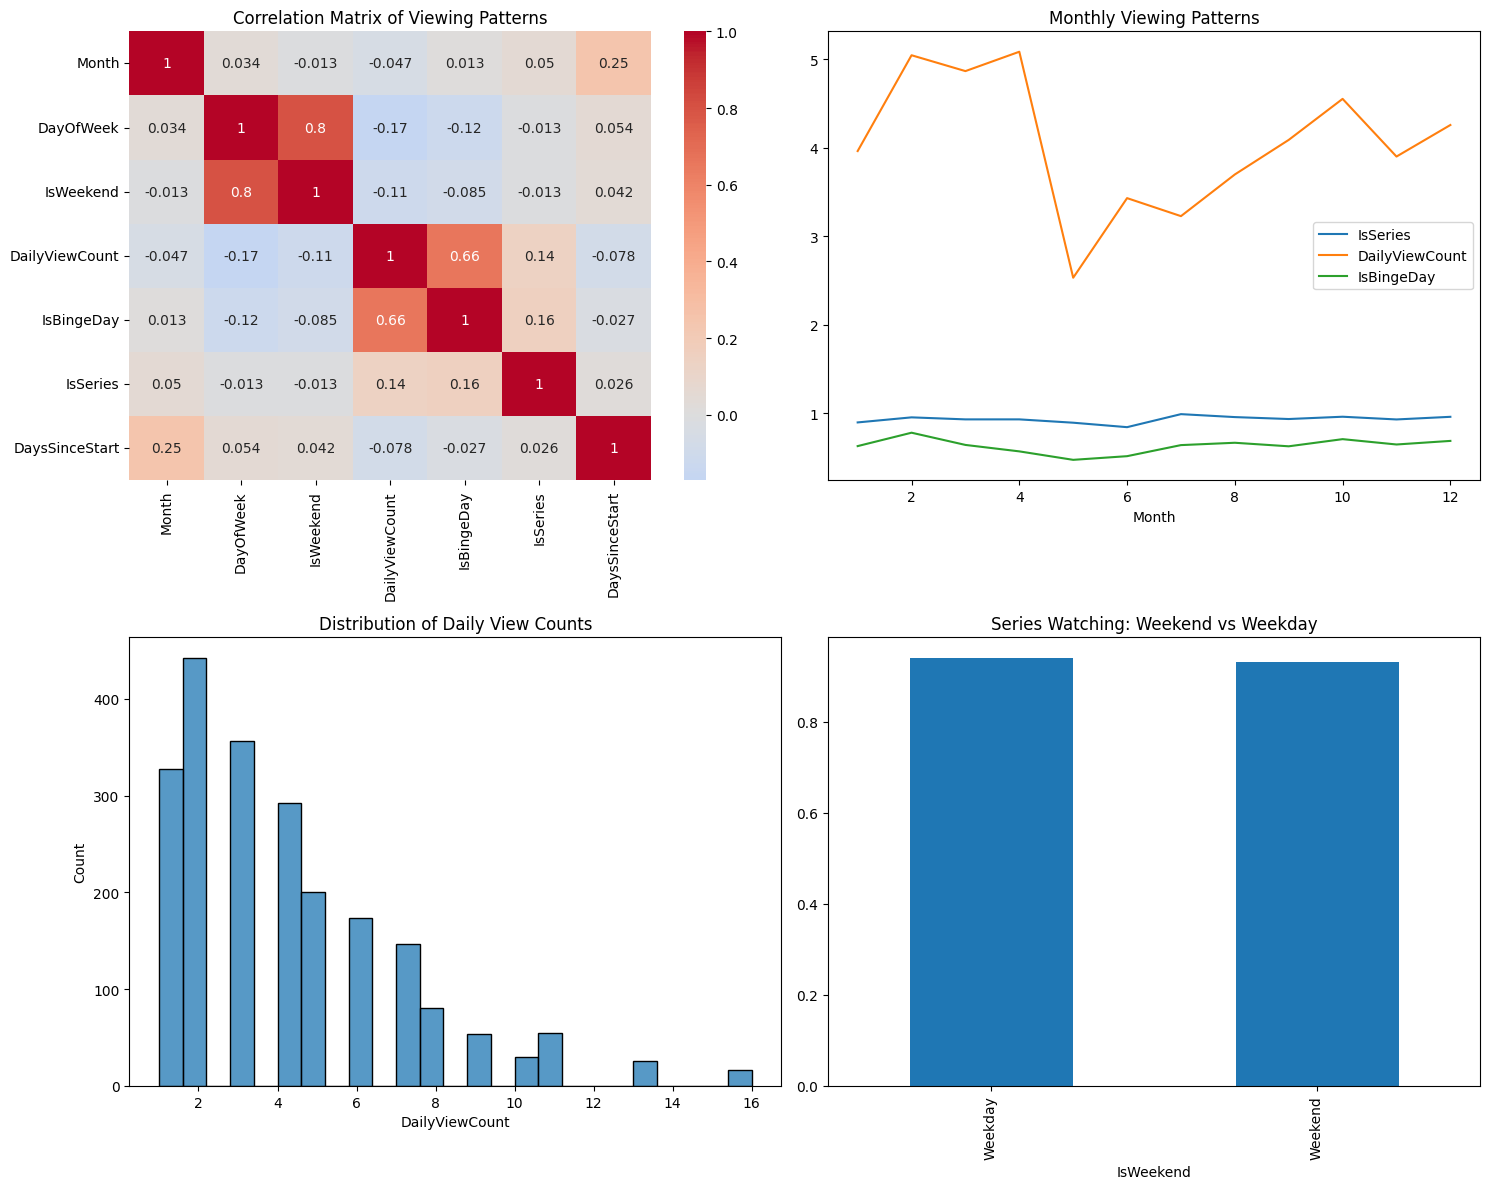

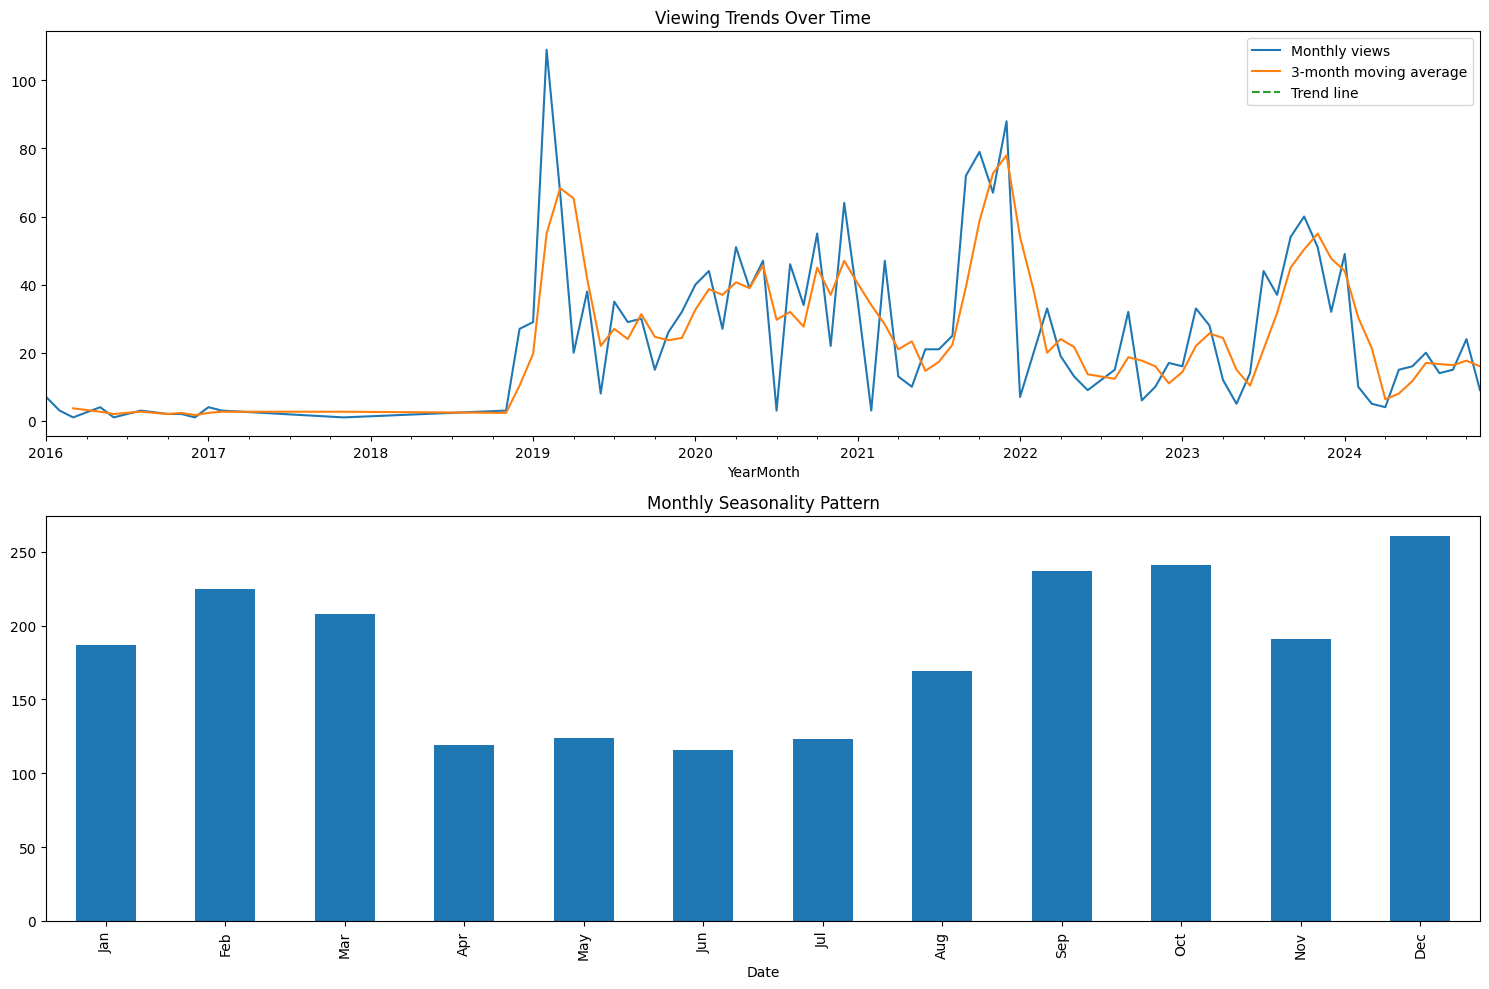

In [16]:
def advanced_viewing_analysis(df):
    """Advanced analysis including correlations and viewing patterns"""
    
    # 1. Create additional features for correlation
    df_analysis = df.copy()
    df_analysis['Date'] = pd.to_datetime(df_analysis['Date'])
    df_analysis['Month'] = df_analysis['Date'].dt.month
    df_analysis['DayOfWeek'] = df_analysis['Date'].dt.dayofweek
    df_analysis['IsWeekend'] = df_analysis['DayOfWeek'].isin([5, 6]).astype(int)
    df_analysis['DaysSinceStart'] = (df_analysis['Date'] - df_analysis['Date'].min()).dt.days
    
    # Count daily views
    daily_views = df_analysis.groupby(df_analysis['Date'].dt.date).size()
    df_analysis['DailyViewCount'] = df_analysis['Date'].dt.date.map(daily_views)
    
    # Is it a binge day? (3+ views)
    df_analysis['IsBingeDay'] = (df_analysis['DailyViewCount'] >= 3).astype(int)
    
    # Content type (1 for series, 0 for movies)
    df_analysis['IsSeries'] = (df_analysis['Episode'] != 'Movie').astype(int)
    
    # 2. Create correlation matrix
    correlation_features = [
        'Month', 'DayOfWeek', 'IsWeekend', 'DailyViewCount',
        'IsBingeDay', 'IsSeries', 'DaysSinceStart'
    ]
    
    correlation_matrix = df_analysis[correlation_features].corr()
    
    # 3. Analyze viewing patterns over time
    monthly_series_ratio = df_analysis.groupby('Month').agg({
        'IsSeries': 'mean',
        'DailyViewCount': 'mean',
        'IsBingeDay': 'mean'
    })
    
    # 4. Weekend vs Weekday analysis
    weekend_patterns = df_analysis.groupby('IsWeekend').agg({
        'IsSeries': ['mean', 'count'],
        'DailyViewCount': 'mean',
        'IsBingeDay': 'mean'
    })
    
    # 5. Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Correlation matrix heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax1)
    ax1.set_title('Correlation Matrix of Viewing Patterns')
    
    # Monthly patterns
    monthly_series_ratio.plot(ax=ax2)
    ax2.set_title('Monthly Viewing Patterns')
    ax2.set_xlabel('Month')
    
    # Daily view count distribution
    sns.histplot(data=df_analysis, x='DailyViewCount', ax=ax3)
    ax3.set_title('Distribution of Daily View Counts')
    
    # Weekend vs Weekday comparison
    weekend_patterns['IsSeries']['mean'].plot(kind='bar', ax=ax4)
    ax4.set_title('Series Watching: Weekend vs Weekday')
    ax4.set_xticklabels(['Weekday', 'Weekend'])
    
    plt.tight_layout()
    
    # 6. Statistical tests and insights
    print("\nKey Insights:")
    
    # Test if weekend viewing is significantly different
    weekend_vs_weekday = stats.ttest_ind(
        df_analysis[df_analysis['IsWeekend'] == 1]['DailyViewCount'],
        df_analysis[df_analysis['IsWeekend'] == 0]['DailyViewCount']
    )
    print(f"Weekend vs Weekday viewing difference p-value: {weekend_vs_weekday.pvalue:.4f}")
    
    # Binge watching patterns
    print("\nBinge Watching Patterns:")
    print(f"Percentage of binge days: {df_analysis['IsBingeDay'].mean()*100:.1f}%")
    print(f"Average views on binge days: {df_analysis[df_analysis['IsBingeDay']==1]['DailyViewCount'].mean():.1f}")
    
    # Series vs Movies patterns
    print("\nSeries vs Movies:")
    print(f"Series watching percentage: {df_analysis['IsSeries'].mean()*100:.1f}%")
    print(f"Series on weekends: {df_analysis[df_analysis['IsWeekend']==1]['IsSeries'].mean()*100:.1f}%")
    print(f"Series on weekdays: {df_analysis[df_analysis['IsWeekend']==0]['IsSeries'].mean()*100:.1f}%")
    
    return {
        'correlation_matrix': correlation_matrix,
        'monthly_patterns': monthly_series_ratio,
        'weekend_patterns': weekend_patterns,
        'daily_stats': df_analysis.groupby('DayOfWeek')['DailyViewCount'].mean()
    }

# Add trend analysis
def analyze_viewing_trends_advanced(df):
    """Analyze long-term viewing trends and patterns"""
    
    df_trends = df.copy()
    df_trends['Date'] = pd.to_datetime(df_trends['Date'])
    df_trends['YearMonth'] = df_trends['Date'].dt.to_period('M')
    
    # Monthly trends
    monthly_counts = df_trends.groupby('YearMonth').size()
    
    # Calculate moving averages
    rolling_mean = monthly_counts.rolling(window=3).mean()
    
    # Trend analysis
    from scipy import stats
    x = np.arange(len(monthly_counts))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, monthly_counts)
    
    # Seasonality check
    month_seasonality = df_trends.groupby(df_trends['Date'].dt.month).size()
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Monthly trend with rolling average
    monthly_counts.plot(ax=ax1, label='Monthly views')
    rolling_mean.plot(ax=ax1, label='3-month moving average')
    ax1.plot(x, slope * x + intercept, '--', label='Trend line')
    ax1.set_title('Viewing Trends Over Time')
    ax1.legend()
    
    # Monthly seasonality
    month_seasonality.plot(kind='bar', ax=ax2)
    ax2.set_title('Monthly Seasonality Pattern')
    ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.tight_layout()
    
    # Print insights
    print("\nTrend Analysis:")
    print(f"Overall trend slope: {slope:.2f} views per month")
    print(f"R-squared value: {r_value**2:.3f}")
    print(f"Trend p-value: {p_value:.4f}")
    
    return {
        'monthly_counts': monthly_counts,
        'trend_stats': {'slope': slope, 'r_squared': r_value**2, 'p_value': p_value},
        'seasonality': month_seasonality
    }

# Execute both analyses
correlation_results = advanced_viewing_analysis(netflix_data_cleaned)
trend_results = analyze_viewing_trends_advanced(netflix_data_cleaned)